In [124]:
import joblib
import json 
import requests

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

import xgboost as xgb

from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval

In [125]:
# Read in the data
data = pd.read_csv('Turbine_Data.csv')

# The unnamed column seems to be dates. Convert column to datetime and set as index
data = data.rename(columns={'Unnamed: 0': 'Date'})
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

# Print out last five rows
data.tail()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,...,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-30 23:10:00+00:00,70.044465,27.523741,45.711129,1.515669,1.950088,1.950088,0.0,59.821165,55.193793,1029.870744,...,58.148777,39.008931,36.476562,178.0,13.775785,9.234004,2.0,G01,178.0,3.533445
2020-03-30 23:20:00+00:00,40.833474,27.602882,45.598573,1.702809,2.136732,2.136732,0.0,59.142038,54.798545,1030.160478,...,57.550367,39.006759,36.328125,178.0,8.088928,9.229370,2.0,G01,178.0,3.261231
2020-03-30 23:30:00+00:00,20.777790,27.560925,45.462045,1.706214,2.139664,2.139664,0.0,58.439439,54.380456,1030.137822,...,57.099335,39.003815,36.131944,178.0,4.355978,9.236802,2.0,G01,178.0,3.331839
2020-03-30 23:40:00+00:00,62.091039,27.810472,45.343827,1.575352,2.009781,2.009781,0.0,58.205413,54.079014,1030.178178,...,56.847239,39.003815,36.007805,190.0,12.018077,9.237374,2.0,G01,190.0,3.284468
2020-03-30 23:50:00+00:00,68.664425,27.915828,45.231610,1.499323,1.933124,1.933124,0.0,58.581716,54.080505,1029.834789,...,56.741040,39.003815,35.914062,203.0,14.439669,9.235532,2.0,G01,203.0,3.475205


In [126]:
# Shift the values of the power 
# Predicted value if for 10 Minutes in the future
data['ActivePower'] = data.ActivePower.shift(-1)
data.tail(10)

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,...,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-30 22:20:00+00:00,147.223697,27.583998,46.363847,0.682622,1.115857,1.115857,0.0,62.243332,56.684490,1030.098267,...,61.174030,39.982463,37.375000,188.000000,28.709709,9.234751,2.0,G01,188.000000,3.954384
2020-03-30 22:30:00+00:00,117.706939,27.577234,46.223171,0.633278,1.067585,1.067585,0.0,62.154613,56.514011,1030.347656,...,60.651139,39.733410,37.210633,188.000000,29.910468,9.230950,2.0,G01,188.000000,4.190217
2020-03-30 22:40:00+00:00,99.670237,27.508489,46.088975,1.023465,1.456349,1.456349,0.0,61.789414,56.285359,1029.891333,...,60.123138,39.024528,37.034593,184.666667,22.846505,9.233694,2.0,G01,184.666667,3.949295
2020-03-30 22:50:00+00:00,90.331065,27.440426,45.941079,1.237270,1.671673,1.671673,0.0,60.797234,55.886593,1029.654240,...,59.359762,39.035784,36.846869,178.000000,20.129394,9.234792,2.0,G01,178.000000,3.920965
2020-03-30 23:00:00+00:00,70.044465,27.581193,45.819084,1.411808,1.846226,1.846226,0.0,60.275851,55.552022,1029.805433,...,58.729390,39.010394,36.650659,178.000000,17.792888,9.235228,2.0,G01,178.000000,3.612339
2020-03-30 23:10:00+00:00,40.833474,27.523741,45.711129,1.515669,1.950088,1.950088,0.0,59.821165,55.193793,1029.870744,...,58.148777,39.008931,36.476562,178.000000,13.775785,9.234004,2.0,G01,178.000000,3.533445
2020-03-30 23:20:00+00:00,20.777790,27.602882,45.598573,1.702809,2.136732,2.136732,0.0,59.142038,54.798545,1030.160478,...,57.550367,39.006759,36.328125,178.000000,8.088928,9.229370,2.0,G01,178.000000,3.261231
2020-03-30 23:30:00+00:00,62.091039,27.560925,45.462045,1.706214,2.139664,2.139664,0.0,58.439439,54.380456,1030.137822,...,57.099335,39.003815,36.131944,178.000000,4.355978,9.236802,2.0,G01,178.000000,3.331839
2020-03-30 23:40:00+00:00,68.664425,27.810472,45.343827,1.575352,2.009781,2.009781,0.0,58.205413,54.079014,1030.178178,...,56.847239,39.003815,36.007805,190.000000,12.018077,9.237374,2.0,G01,190.000000,3.284468


In [127]:
# Fill missing values using ffull and bfill and 
# confirm that we don't have any null values left in the dataset
data = data.fillna(method='ffill').fillna(method='bfill')
#data.isnull().sum()

In [128]:
#data.info()

Text(0, 0.5, 'Power generated')

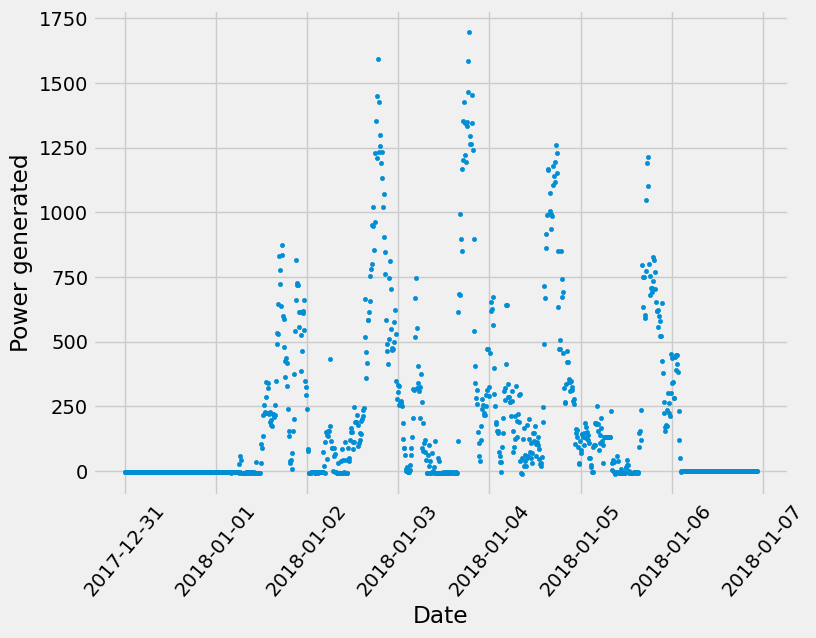

In [129]:
# Use tivethirtyeight as a sytle because it looks really nice
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 6))

# Plot the first 1000 datapoints of power generated
plt.scatter(data.index[:1000], data['ActivePower'][:1000], marker='.')

# Set labels and rotate x labels for better readabilty
plt.xlabel('Date')
plt.xticks(rotation=50)
plt.ylabel('Power generated')

Text(0, 0.5, 'Wind speed')

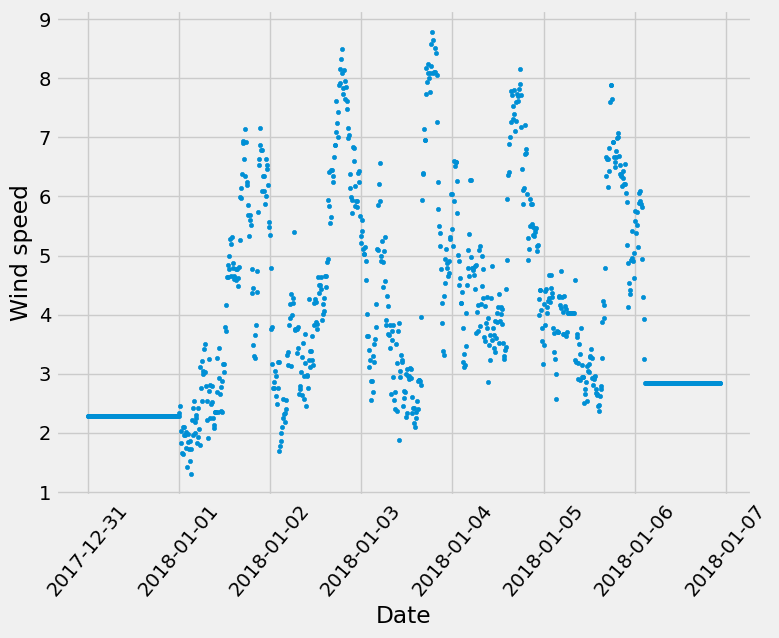

In [130]:
# Do the same as above, but with wind speed
plt.figure(figsize=(8, 6))

# Plot the first 1000 datapoints of wind speed 
plt.scatter(data.index[:1000], data['WindSpeed'][:1000], marker='.')

# Set labels and rotate x labels for better readabilty
plt.xlabel('Date')
plt.xticks(rotation=50)
plt.ylabel('Wind speed')

Text(0, 0.5, 'Number of days')

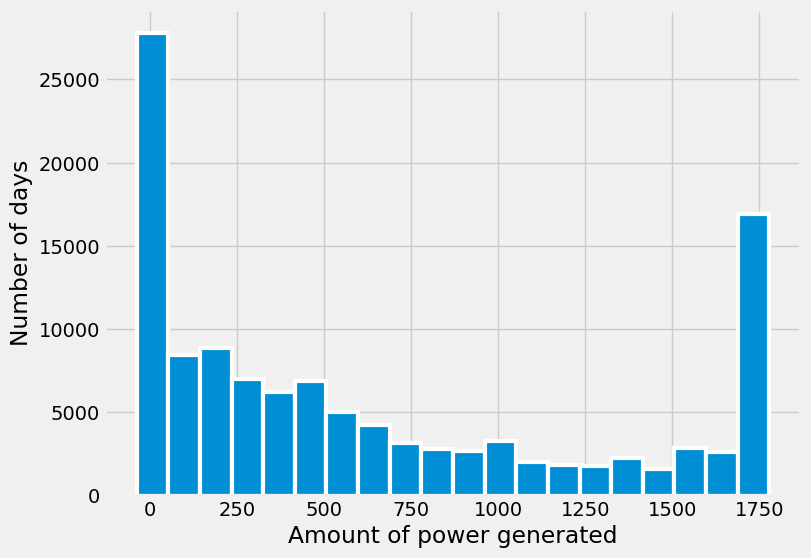

In [131]:
plt.figure(figsize=(8, 6))

# Plot the generated power in a histogram to get a feel of much much energy was usually generated
data.ActivePower.plot(kind='hist', linewidth=3, edgecolor='white', bins=20)

# Set labels
plt.xlabel('Amount of power generated')
plt.ylabel('Number of days')

In [132]:
# The columns WTG is only a single value, so it might be dropped
data.WTG.value_counts()

G01    118224
Name: WTG, dtype: int64

In [133]:
# Split up data into X (features) any y (targets)
X = data.drop(['ActivePower','ControlBoxTemperature', 'WTG'], axis=1)
y = data.ActivePower.values

In [134]:
# Train-test-split for later evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [136]:
# Parameter space for XGBoost regression
# xgb_space = {
#     'learning_rate': hp.choice('learning_rate', [0.01, 0.02, 0.03, 0.04, 0.05, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
#     'n_estimators': hp.choice('n_estimators', [80, 90, 100, 120, 130, 140, 150, 160, 170, 200, 250, 300, 350, 400, 450, 500]),
#     'max_depth' : hp.choice('max_depth', range(3, 21, 1)),
#     'gamma' : hp.choice('gamma', [i/10.0 for i in range(0, 5)]),
#     'colsample_bytree' : hp.choice('colsample_bytree', [i/10.0 for i in range(3, 10)]),     
#     'subsample' : hp.choice('subsample', [0.6, 0.7, 0.8, 0.9, 1.0]), 
#     'min_child_weight' : hp.choice('min_child_weight', [0, 0.1, 0.2, 0.5, 1, 2, 5, 10]),
# }

# # Objective function
# def xgb_objective(params):
#     # Instantiate model
#     xgbr = xgb.XGBRegressor(seed=0, **params, eval_metric='rmse')

#     # Fit and predict
#     xgbr.fit(X_train, y_train)
#     y_hat = xgbr.predict(X_test)
    
#     # Calculate the root mean squared error
#     rmse = mean_squared_error(y_test, y_hat, squared=False)
#     print ("SCORE:", rmse)

#     # Retrun loss, status and model
#     return {'loss': rmse, 'status': STATUS_OK, 'model': xgbr}

# # Trials to track progress
# bayes_trials = Trials()

# # Use the space and objective above to find best parameters
# xgb_best = fmin(fn=xgb_objective, space=xgb_space, algo=tpe.suggest, max_evals=28, trials=bayes_trials)

In [137]:
# # Print the values of the best parameters
# xgb_params = space_eval(xgb_space, xgb_best)
# print(xgb_params)

In [138]:
# xgb_reg = xgb.XGBRegressor(**xgb_params)
# xgb_reg.fit(X_train, y_train)

# y_hat = xgb_reg.predict(X_test)
# print(math.sqrt(mean_squared_error(y_test, y_hat)))

In [139]:
# # Plot importance of features. Unsurprisingly, Temperature and Windspeed are among the most important features
# xgb.plot_importance(xgb_reg)
# plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=58094438-cd92-41fa-8d58-ab103e551863' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

In [140]:
# Define hyperparamter space
dt_space = {
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 10)),
    'max_features': hp.choice('max_features', range(1, 100)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 5)),
    'min_weight_fraction_leaf': hp.choice('min_weight_fraction_leaf', np.linspace(0, 0.5, num=10))
    }

# Objective function
def dt_objective(params):
    # Instantiate model
    dt = DecisionTreeRegressor(**params)

    # Fit and predict
    dt.fit(X_train, y_train)
    y_hat = dt.predict(X_test)
    
    # Calculate the root mean squared error
    rmse = mean_squared_error(y_test, y_hat, squared=False)
    print ("SCORE:", rmse)

    # Retrun loss, status and model
    return {'loss': rmse, 'status': STATUS_OK, 'model': dt}

# Trials to track progress
bayes_trials = Trials()

# Use the space and objective above to find best parameters
dt_best = fmin(fn=dt_objective, space=dt_space, algo=tpe.suggest, max_evals=28, trials=bayes_trials)

SCORE:                                                
268.58079515040777                                    
SCORE:                                                                          
275.0681585388465                                                               
SCORE:                                                                          
336.637285628789                                                                
SCORE:                                                                          
275.06815853884655                                                              
SCORE:                                                                          
324.97758691809867                                                              
SCORE:                                                                          
207.56725050955504                                                              
SCORE:                                                                          

In [141]:
# Print the values of the best parameters
dt_params = space_eval(dt_space, dt_best)
print(dt_params)

{'max_depth': 8, 'max_features': 28, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0}


In [142]:
dtr = DecisionTreeRegressor(**dt_params)
dtr.fit(X_train, y_train)

y_hat = dtr.predict(X_test)
print(math.sqrt(mean_squared_error(y_test, y_hat)))

142.78569297308292


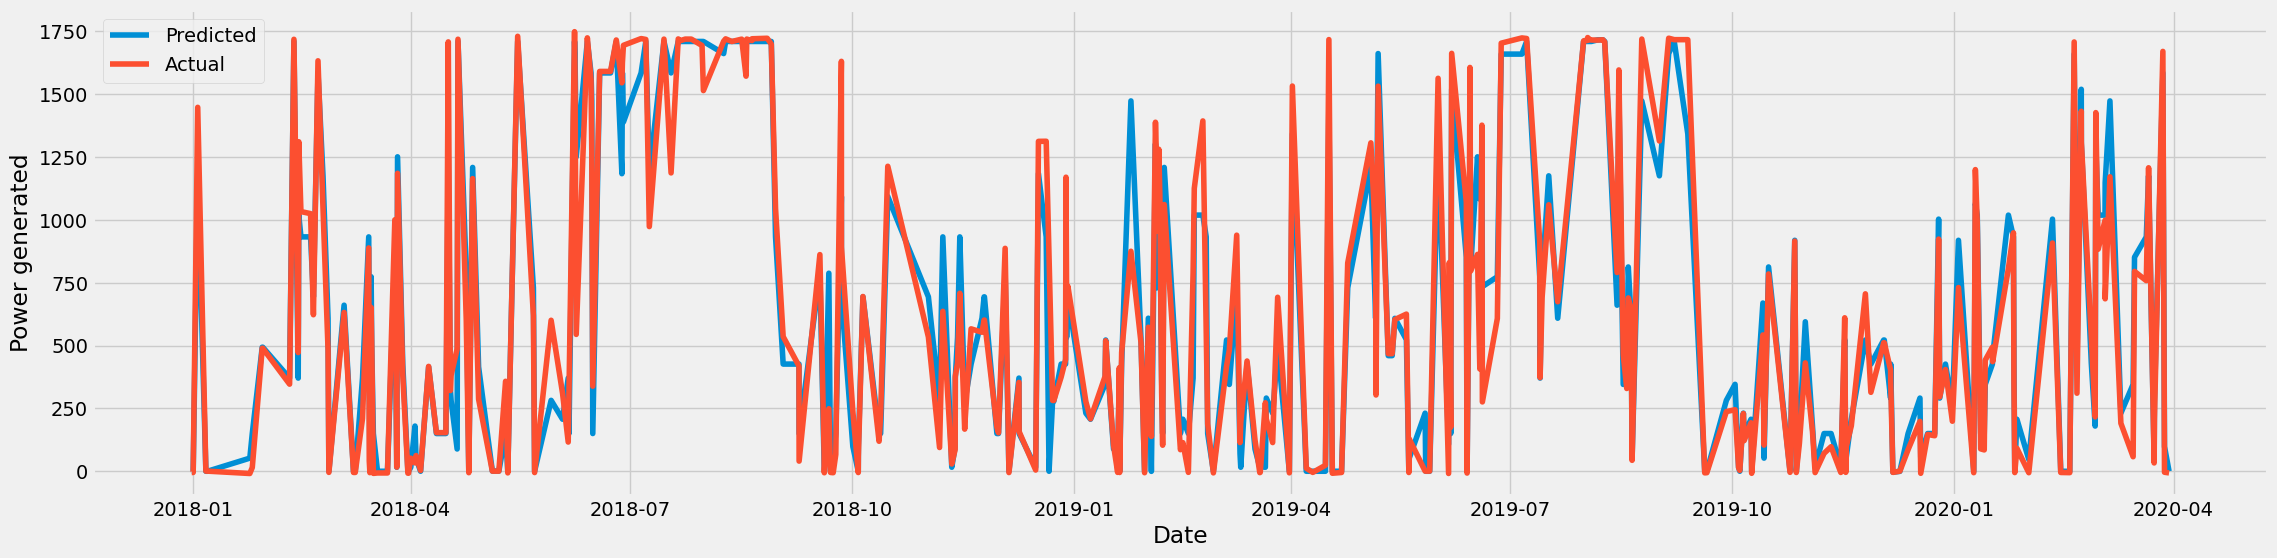

In [143]:
plt.figure(figsize=(25, 6))

# Plot the predicted and the acutal values on a line plot to see how well our model performed
sns.lineplot(x=X_test.index[:360], y=y_hat[:360], alpha=1, label='Predicted')
sns.lineplot(x=X_test.index[:360], y=y_test[:360], alpha=1, label='Actual')

# Labels and legend
plt.xlabel('Date')
plt.ylabel('Power generated')
plt.legend()
plt.show()

In [144]:
joblib.dump(dtr, 'windpred_model.pkl')

['windpred_model.pkl']

In [145]:
# Take a subset of our test data and save it so JSON format
entry = X_test.head(5)
entry.to_json('data.json')

In [146]:
# Load the JSON data
with open('data.json') as f:
    data = json.load(f)

In [148]:
# Send request to our serverless function
URL = 'http://localhost:7071/api/WindForecasting'
headers = {'Content-type': 'application/json'}
req = requests.post(URL, json=json.dumps(data))
print(req.text)

[
  {
    "energy_production": 230.78735064154228
  },
  {
    "energy_production": 88.20743451684292
  },
  {
    "energy_production": -0.44728666191384386
  },
  {
    "energy_production": -0.44728666191384386
  },
  {
    "energy_production": 932.3921582469286
  }
]


In [149]:
y_test[:5]

array([ 113.71313525,  103.12529175,   -6.15217021,   -5.44992136,
       1312.989025  ])